# 1. 加载Overlay，定义DMA对象

In [1]:
from pynq import Overlay, allocate
import pynq.lib.dma

overlay = Overlay('./gen_bit/lstm.bit')  # 加载Overlay
dma = overlay.axi_dma_0  # 定义DMA对象

/usr/local/lib/python3.6/dist-packages/pynq/ps.py:464: UserWarning: Setting frequency to the closest possible value 98.8879MHz.
  round(freq_high / q0, 5)))


# 2. 解析测试集图片和数据

In [2]:
from pynq import allocate
import numpy as np

battery = np.load('./data/tensor.npy')

num_batchs = 80
num_len = 20
num_dim = 5
data = []
print(battery[1].flatten())
datas = allocate(shape = (num_batchs, num_len*num_dim), dtype = np.float32)
for i in range(num_batchs): 
    datas[i] = battery[i+2]


[1.         0.6696385  0.72511196 0.4777005  1.         0.9674906
 0.7472773  0.7003887  0.5438512  0.98601973 0.95254683 0.76684326
 0.         0.4823995  0.7886798  0.91428965 0.8652719  0.5867588
 0.37993723 0.9257437  0.91502345 0.8239696  0.13647924 0.42872897
 0.7021799  0.90989363 0.7258848  0.6722021  0.6277373  0.44277075
 0.9008759  0.7048835  0.6595165  0.7504183  0.28433898 0.88621545
 0.9300703  0.61508083 0.32860306 0.7876212  0.87004435 0.9195224
 0.58057904 0.26649562 0.71854484 0.87338394 0.73341244 0.61144733
 0.73618513 0.18765622 0.85752237 0.9618857  0.62487006 0.35695404
 0.7118052  0.85814023 0.90570563 0.27825758 0.39818162 0.61117816
 0.8455665  0.98730004 0.7405602  0.3392388  0.6496757  0.83223784
 0.9912605  0.45434704 0.3804428  0.61420894 0.8277717  0.9917108
 0.48885658 0.4162122  0.60529184 0.84034723 0.903423   0.38023642
 0.40184918 0.50857896 0.83908635 0.89456904 0.63464785 0.4351036
 0.44721422 0.8385168  0.90747154 0.3645802  0.4392051  0.492538
 0

Text(0.5,1,'Discharge B0055')

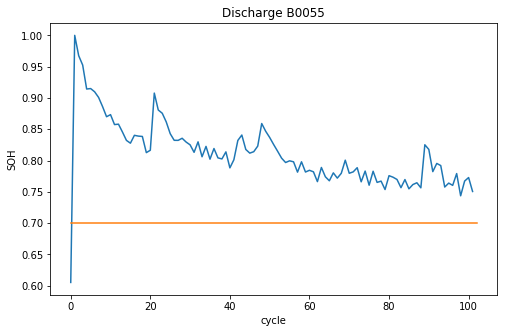

In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt

origin = np.load('./data/origin.npy')
datai = np.load('./data/pdata.npy')
plt.figure(figsize=(8, 5))
plt.plot([i for i in range(len(origin))], origin, label='SOH')
plt.plot([0.,len(origin)], [0.70, 0.70], label='Threshold')
plt.xlabel('cycle')
plt.ylabel('SOH')
plt.title('Discharge B0055')

# 3. 利用IP核加速LSTM推导

Result: 0.972511, time: 0.007634s
Result: 0.944485, time: 0.007522s
Result: 0.785233, time: 0.007524s
Result: 0.827264, time: 0.007529s
Result: 0.952064, time: 0.007502s
Result: 0.766403, time: 0.007500s
Result: 0.842450, time: 0.007512s
Result: 0.812260, time: 0.007509s
Result: 0.813158, time: 0.007517s
Result: 0.813447, time: 0.007524s
Result: 0.843874, time: 0.007497s
Result: 0.843177, time: 0.007526s
Result: 0.822942, time: 0.007507s
Result: 0.787301, time: 0.007493s
Result: 0.792417, time: 0.007499s
Result: 0.835408, time: 0.007502s
Result: 0.849783, time: 0.007501s
Result: 0.868182, time: 0.007523s
Result: 0.870076, time: 0.007505s
Result: 0.833153, time: 0.007522s
Result: 0.822753, time: 0.007511s
Result: 0.817211, time: 0.007503s
Result: 0.825913, time: 0.007501s
Result: 0.824769, time: 0.007530s
Result: 0.812293, time: 0.007508s
Result: 0.798493, time: 0.007500s
Result: 0.832014, time: 0.007527s
Result: 0.782570, time: 0.007495s
Result: 0.811554, time: 0.007512s
Result: 0.7881

Text(0.5,1,'Discharge B0018')

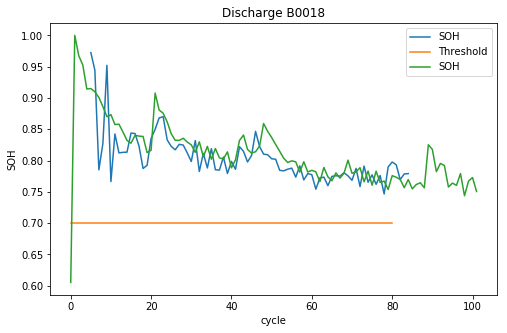

In [6]:
import time
hw_time = [0] * num_batchs
out_buf = allocate(shape=(num_batchs, 1), dtype = np.float32)
for i in range (num_batchs):
    t0 = time.time()
    dma.sendchannel.transfer(datas[i])  # 调用DMA将待预测图片数据传输到IP核
    dma.recvchannel.transfer(out_buf[i])  # 调用DMA从IP核获取RNN的推导结果
    dma.sendchannel.wait()  # 等待DMA发送完成
    dma.recvchannel.wait()  # 等待DMA接收完成
    t1 = time.time()
    hw_time[i] = t1 - t0

    # out_list = np.array(out_buf[index[i]])
    print('Result: %f,' % out_buf[i], 'time: {:1.6f}s'.format(hw_time[i]))
    
plt.figure(figsize=(8, 5))
plt.plot([i for i in range(5,len(out_buf)+5)], out_buf, label='SOH')
plt.plot([0,len(out_buf)], [0.70, 0.70], label='Threshold')
plt.plot([i for i in range(len(origin))], origin, label='SOH')
# plt.plot([i for i in range(len(datai))], datai, label='SOH')
plt.legend()
plt.xlabel('cycle')
plt.ylabel('SOH')
plt.title('Discharge B0018')